In [65]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

import keras
from keras.optimizers import RMSprop
import keras.utils

from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.noise import GaussianNoise
from keras import backend as K

from IPython import display



In [146]:
import tensorflow as tf
tf. __version__

'2.3.0'

In [66]:
LAYER_BLOCKS = 0
LAYER_COINS = 1
LAYER_ENEMIES = 2
NLAYERS = 3

class GameMap:
    def __init__(self):
        self.levels = []
        self.widths = []
        self.heights = []
        self.nmaps = 0
        
        with open("Zelda/zelda.json") as f:
            self.tiledefs = json.load(f)
        
        for fname in sorted(glob.glob("Zelda/zelda/zelda_lvl*.txt")):
            #print(fname)
            with open(fname) as f:
                data = [line.strip() for line in f.readlines()]
                self.levels.append(data)
                self.heights.append(len(data))
                self.widths.append(len(data[0]))
                self.nmaps += 1

    def getMaps(self, level=0):
        layers = np.ndarray((self.heights[level], self.widths[level], NLAYERS), dtype=np.bool)
        layers.fill(0)
        for r, row in enumerate(self.levels[level]):
            for c, tile in enumerate(row):
                if tile in ('1','2','3'):
                    layers[r,c,LAYER_ENEMIES] = 1
                elif tile in ('+'):
                    layers[r,c,LAYER_COINS] = 1
                elif tile in ('w'):
                    pass
                else:
                    layers[r,c,LAYER_BLOCKS] = 1
                
        return layers[:,:,LAYER_BLOCKS]
    
    def getMapsRange(self, from_level=0, to_level=None):
        if to_level == None:
            to_level = from_level + 1
        return np.concatenate([self.getMaps(i) for i in range(from_level, to_level)], axis=1)
            
    def getMapsRangeWindowed(self, windowsize = 2, from_level=0, to_level=None):
        if to_level == None:
            to_level = from_level + 1
        a = self.getMapsRange(from_level, to_level)
        windows = np.concatenate([np.roll(a,-shift,axis=1) for shift in range(windowsize)])
        return windows
            

In [67]:
gm = GameMap()
a = gm.getMapsRangeWindowed(4,0,5)
at = a.transpose()


In [68]:
class LossHistory(Callback):
    def __init__(self, layer_index, X_train=None, y_train=None):
        super(Callback, self).__init__()
        self.layer_index = layer_index
        self.previous_model_params_ = None
        if X_train and X_train.shape[0] >= 1000:
            mask = np.random.choice(X_train.shape[0], 1000)
            self.X_train_subset = X_train[mask]
            self.y_train_subset = y_train[mask]
        else:
            self.X_train_subset = X_train
            self.y_train_subset = y_train

    def on_train_begin(self, logs={}):
        #self.model_params would be ['layer1_W', 'layer2_b', 'layer2_W', 'layer2_b',...]
        self.train_batch_loss = []
        self.train_acc = []
        self.val_acc = []
        self.layer_out = []
        self.model_params = []
        self.gradients = []
        self.init_params = self.get_model_params()
        self.previous_model_params_ = self.init_params

    def on_batch_end(self, batch, logs={}):
        self.train_batch_loss.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        #use W' = W + dW to calculate the gradients
        current_model_params = self.get_model_params()
        gradients = [(param - prev_param) for (param, prev_param) in zip(current_model_params,
                                                                         self.previous_model_params_)]
        self.gradients.append(gradients)
        self.previous_model_params_ = current_model_params
        self.model_params.append(current_model_params)

        self.layer_out.append(self.get_layer_out())

        if self.X_train_subset:
            val_epoch_acc = logs.get('val_acc')
            self.val_acc.append(val_epoch_acc)
            train_epoch_acc = self.model.evaluate(self.X_train_subset, self.y_train_subset,
                                                  show_accuracy=True, verbose=0)[1]
            self.train_acc.append(train_epoch_acc)
            print('(train accuracy, val accuracy): (%.4f, %.4f)' % (train_epoch_acc, val_epoch_acc))

    def get_layer_out(self):
        layer_index = self.layer_index
        get_activation = theano.function([self.model.layers[0].input],
                                       self.model.layers[layer_index].get_output(train=False), allow_input_downcast=True)
        return get_activation(self.X_train_subset)

    def get_model_params(self):
        return [param.get_value() for param in self.model.params]

In [136]:
in_out_size = at.shape[1]
hiddensize =2 #int(in_out_size*.25)
model = Sequential()
model.add(Dense(in_out_size/1, input_shape=(in_out_size,)))
model.add(Activation("sigmoid"))

model.add(Dense(in_out_size/2))
model.add(Activation("sigmoid"))

model.add(Dense(hiddensize))
model.add(Activation("sigmoid"))

model.add(Dense(in_out_size/2))
model.add(Activation("sigmoid"))

model.add(Dense(in_out_size))
model.add(Activation("sigmoid"))

# "mse" seems to be the best loss function for the problem
# "RMSprop" seems to be the best, with "adadelta" also good
optimizer = RMSprop()
losshistory = LossHistory(0)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])



In [137]:
model.layers

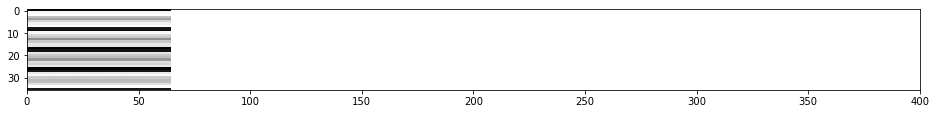

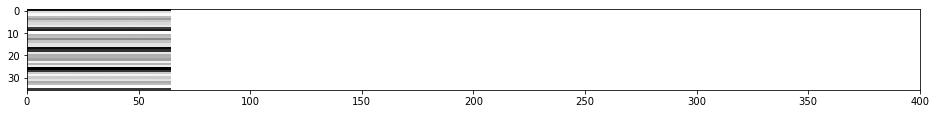

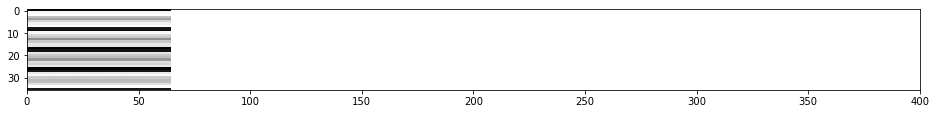

In [138]:
for i in range(2):
    history = model.fit(at, at, epochs=50, batch_size=64, shuffle=True, verbose=False)
    pt = model.predict(at)
    p = pt.transpose()
    fig, axes = plt.subplots(1,1,figsize=(16,4))
    axes.imshow(p,cmap="gray", interpolation="nearest");
    axes.set_xlim(0,400)
    display.clear_output(wait=True)
    display.display(plt.gcf());
    #print((i, history.history['acc'][-1]))
    #axes[1].imshow(a,cmap="gray", interpolation="nearest")

In [139]:
w1 = model.get_weights()
model.fit(at, at, epochs=1, batch_size=64, shuffle=True, verbose=False)
w2 = model.get_weights()
[w2[i]-w1[i] for i in range(len(model.layers))]

1177124e-04,  4.6226382e-04,  6.6629052e-04,
          1.0783672e-03,  5.8007240e-04],
        [ 6.4751506e-04,  1.0918677e-03,  2.4624541e-04, -7.8095496e-04,
          9.6219778e-04,  6.1690807e-04,  5.2994490e-04, -5.7798624e-04,
         -8.0374628e-04,  9.4958395e-04,  1.1668503e-03,  7.2312355e-04,
          2.5150180e-04,  3.7794933e-04,  4.1806698e-04,  6.1471760e-04,
          1.0893941e-03,  6.0801953e-04],
        [ 3.6451593e-04,  1.1445582e-03, -1.0251999e-04, -5.6023896e-04,
          7.9625845e-04,  3.1387806e-04,  1.7425418e-04, -2.9195100e-04,
         -9.2265010e-04,  8.4673613e-04,  1.2031794e-03,  8.4425509e-04,
         -8.4385276e-05,  1.4726073e-05,  8.9544803e-05,  3.3321977e-04,
          1.1046231e-03,  7.8119338e-04],
        [ 3.0399859e-04,  4.9054623e-04,  1.4759600e-04, -2.8690696e-04,
          4.6682358e-04,  2.9674079e-04,  2.0700693e-04, -2.5716424e-04,
         -2.9426813e-04,  4.4053793e-04,  5.1306188e-04,  2.7665496e-04,
          1.1937320e-04,  

In [140]:
model.get_weights()

  [-0.02581975, -0.03450319, -0.2691373 , -0.19746551,  0.21227469,
         -0.19911414, -0.22856268,  0.12147079, -0.3507182 , -0.25430045,
         -0.28617668,  0.2532372 ,  0.0669202 , -0.13870786,  0.13622583,
          0.08489612,  0.05490468, -0.12755856],
        [-0.0390331 , -0.26721844,  0.12039167, -0.10840527,  0.20722751,
          0.29803935, -0.13264239, -0.07095258, -0.27967918,  0.02676915,
          0.23514229, -0.17709655,  0.00416628, -0.07203808, -0.06166018,
         -0.08069219, -0.23390351, -0.14232378],
        [ 0.03698576, -0.0859476 , -0.07579628, -0.09841777,  0.29818004,
          0.35764837,  0.34832463,  0.2233827 , -0.02408789, -0.11883163,
         -0.05023267, -0.12532589,  0.04148493,  0.3691701 ,  0.08821336,
         -0.16006996,  0.32362357,  0.2374581 ],
        [-0.07828988, -0.01897703, -0.12120426, -0.05380713,  0.31633794,
         -0.08168172, -0.04685341,  0.01439182, -0.3104406 ,  0.37105563,
          0.20443568,  0.10279527, -0.1592458

In [141]:
model.layers[0].get_weights()[1].shape

(36,)

89.993225

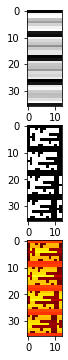

In [142]:
test_a = gm.getMapsRangeWindowed(4, 1)
test_at = test_a.transpose()
test_pt = model.predict(test_at)
test_p = test_pt.transpose()
fig, axes = plt.subplots(3,figsize=(16,6))
axes[0].imshow(test_p,cmap="gray", interpolation="nearest")
axes[1].imshow(test_a,cmap="gray", interpolation="nearest")
axes[2].imshow(test_a-test_p, interpolation="nearest", cmap="hot", vmin=-1, vmax=1)
np.sum(pow(test_a-test_p,2))

In [143]:
model.layers

In [144]:
#modelA = model
modelB = model
#modelC = model

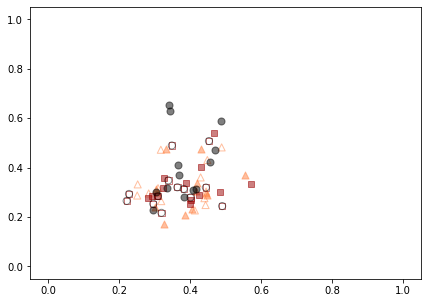

In [152]:
model = modelB

fig, axes = plt.subplots(1,figsize=(7,5))

#get_hidden_layer_output = K.function([model.layers[0].input,  K.learning_phase()], [model.layers[3].output])
xd = 0
yd = 1

if True:
    test_a = gm.getMapsRangeWindowed(4, 0) # W 1-1
    test_at = test_a.transpose()
    hidden_layer_output_A = get_hidden_layer_output([test_at,0])[0]
    plt.scatter(hidden_layer_output_A[:,xd], hidden_layer_output_A[:,yd], alpha=.5, marker='^', color="#FF8040", s=50)

if True:
    test_a = gm.getMapsRangeWindowed(4, 3) # W 2-1
    test_at = test_a.transpose()
    hidden_layer_output_A = get_hidden_layer_output([test_at,0])[0]
    plt.scatter(hidden_layer_output_A[:,xd], hidden_layer_output_A[:,yd], alpha=.5, marker='^', color="#FF8040", s=50,
               facecolor='none')



    
if True:
    test_a = gm.getMapsRangeWindowed(4, 2) # W 1-3
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at,0])[0]
    plt.scatter(hidden_layer_output[:,xd], hidden_layer_output[:,yd], color="#9B0000", alpha=.5, marker="s", s=40)

if True:
    test_a = gm.getMapsRangeWindowed(4, 4) # W 3-3
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at,0])[0]
    plt.scatter(hidden_layer_output[:,xd], hidden_layer_output[:,yd], color="#9B0000", alpha=.5, marker="s", s=40,
               facecolor='None')
    
if True:
    test_a = gm.getMapsRangeWindowed(4, 1) # W 1-2
    test_at = test_a.transpose()
    hidden_layer_output_B = get_hidden_layer_output([test_at,0])[0]
    plt.scatter(hidden_layer_output_B[:,xd], hidden_layer_output_B[:,yd], color="black", alpha=.5, marker="o", s=50)

    
if True:
    test_a = gm.getMapsRangeWindowed(4, 4) # W 4-2
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at,0])[0]
    plt.scatter(hidden_layer_output[:,xd], hidden_layer_output[:,yd], color="black", alpha=.5, marker="o", s=50, 
                facecolor='None')

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)

plt.savefig("hiddenlayerviz.pdf")

In [153]:
hidden_layer_output_A

array([[0.31003457, 0.3168559 , 0.7964645 , 0.54887015, 0.68071306,
        0.19018552, 0.31749123, 0.23429897, 0.38306993, 0.74893814,
        0.28632516, 0.67876345, 0.7190503 , 0.67066   , 0.82873005,
        0.17715687, 0.77876735, 0.23352152, 0.26206315, 0.24786404,
        0.7343335 , 0.22425401, 0.6664648 , 0.88748837, 0.55984694,
        0.6847653 , 0.5162402 , 0.4979626 , 0.24045545, 0.7011496 ,
        0.85577   , 0.7754073 , 0.68948984, 0.45348588, 0.896591  ,
        0.76703507],
       [0.2836848 , 0.29548395, 0.73212016, 0.6105242 , 0.6548825 ,
        0.12592304, 0.47330636, 0.09060907, 0.39043236, 0.70694023,
        0.2903972 , 0.5448977 , 0.6237036 , 0.6152326 , 0.6673668 ,
        0.36968076, 0.90379494, 0.17327365, 0.1631364 , 0.16044924,
        0.71196115, 0.1798943 , 0.54099125, 0.88680905, 0.6311139 ,
        0.6564795 , 0.49167064, 0.50903517, 0.24491465, 0.5894906 ,
        0.86238545, 0.6701453 , 0.6319749 , 0.6363602 , 0.7488635 ,
        0.8736772 ],
      

In [79]:
model.layers

In [154]:
# make some fake input!
h = np.ndarray(shape=(150,2))
h[:,0] = np.random.normal(loc=hidden_layer_output_B[8,0], scale=2, size=150)
h[:,1] = np.random.normal(loc=hidden_layer_output_B[8,1], scale=2, size=150)
#h[:,0].fill(hidden_layer_output_B[8,0])
#h[:,1].fill(hidden_layer_output_B[8,1])
hidden_layer_output_B[8,0], hidden_layer_output_B[8,1]

(0.3448198, 0.6276533)

In [158]:
inject_fake_hidden = K.function([model.layers[5].input],
                                [model.layers[-1].output])

#X = inject_fake_hidden([hidden_layer_output])[0].transpose()
X = inject_fake_hidden([h])[0].transpose()

#th = 0.1
#X[ X <= th] = 0
#X[ X > th] = 1

plt.imshow(X[:14,:], cmap="gray", interpolation="nearest")

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: dense_27/BiasAdd:0


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("dense_25_input:0", shape=(None, 36), dtype=float32) at layer "dense_25". The following previous layers were accessed without issue: []

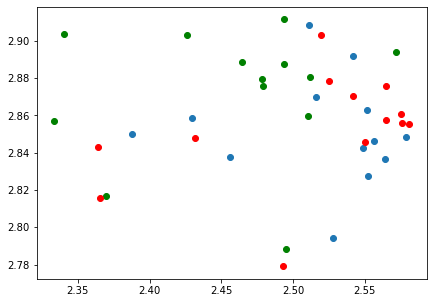

In [176]:
fig, axes = plt.subplots(1,figsize=(7,5))
#inject_fake_hidden = K.function([model.layers[5].input],
#                                [model.layers[-1].output])

#inject_fake_hidden([hidden_layer_output])

if True:
    test_a = gm.getMapsRangeWindowed(4, 0, 1)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=1)

if True:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=1)

if True:
    test_a = gm.getMapsRangeWindowed(4, 2, 3)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=1)

if False:
    test_a = gm.getMapsRangeWindowed(4, 3, 4)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



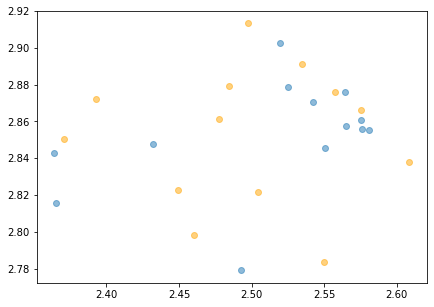

In [174]:
fig, axes = plt.subplots(1,figsize=(7,5))

get_hidden_layer_output = K.function([model.layers[0].input],
                                  [model.layers[4].output])

test_a = gm.getMapsRangeWindowed(4, 2, 3)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 2, 3)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=.5)


test_a = gm.getMapsRangeWindowed(4, 3, 4)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



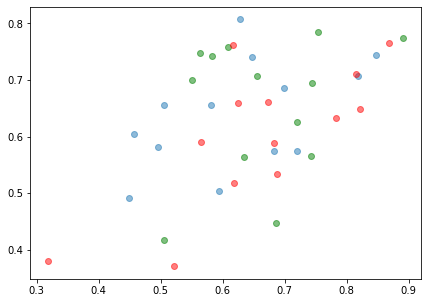

In [171]:
fig, axes = plt.subplots(1,figsize=(7,5))

get_hidden_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

if True:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=.5)

if True:
    test_a = gm.getMapsRangeWindowed(4, 0, 1)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=.5)

if True:
    test_a = gm.getMapsRangeWindowed(4, 3, 4)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 7, 8)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



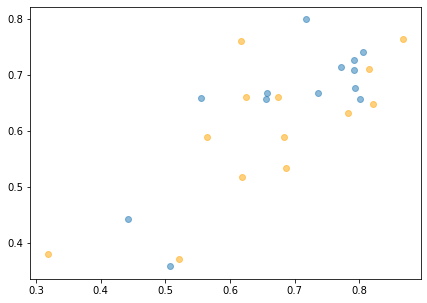

In [164]:
fig, axes = plt.subplots(1,figsize=(7,5))

get_hidden_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

test_a = gm.getMapsRangeWindowed(4, 2, 3)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 2, 3)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=.5)


test_a = gm.getMapsRangeWindowed(4, 3, 4)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



In [202]:
# classify each window
test_a = gm.getMapsRangeWindowed(4, 0, 14)
test_at = test_a.transpose()

d = {}

get_hidden_layer_output = K.function([model.layers[0].input,  K.learning_phase()], [model.layers[6].output])
h = get_hidden_layer_output([test_at,0])[0]
h[ h < .5] = 0
h[ h >= .5] = 1
h[:,0] *= 8
h[:,1] *= 4
h[:,2] *= 2
classes = h.sum(axis=1, dtype="int")
print(np.unique(classes))

for i, c in enumerate(classes):            
    key = tuple(test_at[i])
    if not d.has_key(c):
        d[c] = defaultdict(int)        
    d[c][key] += 1
    




IndexError: list index out of range

In [188]:
def displayclass(d, class_id, nshow=10):
    fig, axes = plt.subplots(1, nshow,figsize=(8,2))
    i =0
    bin_class = bin(class_id)[2:]
    bin_class = "0"*(4-len(bin_class))+bin_class
    axes[i].set_ylabel("%d = %0.4s" % (class_id, bin_class))
    for key, value in sorted(d[class_id].items(), key=lambda kv: kv[1], reverse=True):
        axes[i].imshow(np.reshape(key, (4,14)).transpose(), cmap="gray", interpolation="nearest")
        axes[i].set_title(value)

        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_ticks([])
        i += 1
        if i == nshow:
            break

In [189]:
for key in d.iterkeys():
    displayclass(d, key)

AttributeError: 'dict' object has no attribute 'iterkeys'

In [190]:
displayclass(d,1)

KeyError: 1

In [88]:
displayclass(d, 3)

KeyError: 3

In [89]:
displayclass(d, 8)

KeyError: 8

In [90]:
displayclass(d, 9)

KeyError: 9

In [91]:
displayclass(d, 11)

KeyError: 11

In [92]:
displayclass(d, 12)

KeyError: 12

In [93]:
displayclass(d, 13)

KeyError: 13

In [94]:
displayclass(d, 15)

KeyError: 15

In [95]:
model.layers